# Clustering participants based on their cultural aspects

In [1]:
%%capture

# Boilerplate required to import other notebooks
import ipynb.fs

# From the full "data_preparation" notebook import function(s)
from .full.data_preparation import *

In [2]:
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

## Defining the set of items which represent the cultural aspects of the survey

### In Spanish

In [4]:
def get_cultural_items_esp():
    # Creating lists that includes the items from the cultural-related constructs

    allCulturalItems = ['¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?',
                        '¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?',
                        '¿Conoces autores/as que trabajen produciendo imágenes?',
                        '¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?',
                        'Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?',
                        'Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?',
                        'Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?',
                        'En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?',
                        'Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?']

    mascVsFem = ['¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?',
                 '¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?',
                 '¿Conoces autores/as que trabajen produciendo imágenes?']

    indivVsCollect = ['¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?',
                      'Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?']

    avoidUndertIndex = ['Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?',
                        'Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?',
                        'En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?',
                        'Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?']

    return allCulturalItems, mascVsFem, indivVsCollect, avoidUndertIndex

### In English

In [5]:
def get_cultural_items_en():
    # Creating lists that includes the items from the cultural-related constructs

    allCulturalItems = ['Do you think that images produced by men are different from those made by women?',
                        'Do you think that in the creation of images work more women, or men?',
                        'Do you know authors who work producing images?',
                        'Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?',
                        'When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?',
                        'By reusing an image, can you redefine the message that the sender has thought about?',
                        'When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?',
                        'On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?',
                        'When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?']

    mascVsFem = ['Do you think that images produced by men are different from those made by women?',
                 'Do you think that in the creation of images work more women, or men?',
                 'Do you know authors who work producing images?']

    indivVsCollect = ['Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?',
                      'When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?']

    avoidUndertIndex = ['By reusing an image, can you redefine the message that the sender has thought about?',
                        'When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?',
                        'On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?',
                        'When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?']

    return allCulturalItems, mascVsFem, indivVsCollect, avoidUndertIndex

## Exploring possible clusters

These functions explore the main clusters available in a dataframe. Functions to manage the data (and column names) available in Spanish and English


Also, we include two examples to show how to use the functions

In [6]:
def test_find_clusters_en(dataframe):
    clusters = dataframe.copy(True)
    clusters = drop_text_columns_en(clusters)
    clusters = drop_optional_columns_en(clusters)

    all_cultural_items, _, _, _ = get_cultural_items_en()

    my_subset = all_cultural_items
    clusters = clusters[sorted(clusters, key=lambda x: x not in my_subset)]

    columns_vC = clusters.columns.values.tolist()

    for item in all_cultural_items:
        columns_vC.remove(item)

    z_vCluster = scale(clusters.iloc[:, len(my_subset):])
    z_vCluster = pd.DataFrame(z_vCluster, columns=columns_vC)

    display(z_vCluster.head())

    # Fitting our model.
    cluster_tree = linkage(z_vCluster, 'ward')

    # Ploting our dendrogram.
    colors = ['g', 'b', 'r', 'p', 'y', 'b', 'w']
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sources')
    plt.ylabel('Distance')
    dendrogram(cluster_tree, leaf_rotation=80.,
               leaf_font_size=14.,  color_threshold=4.5)
    plt.show()

    fancy_dendrogram(
        cluster_tree,
        truncate_mode='lastp',
        p=12,
        leaf_rotation=80.,
        leaf_font_size=14.,
        show_contracted=True,
        annotate_above=5,  # useful in small plots so annotations don't overlap
        color_threshold=4.5,
    )

    plt.show()

In [7]:
def test_find_clusters_esp(dataframe):
    clusters = dataframe.copy(True)
    clusters = drop_text_columns_esp(clusters)
    clusters = drop_optional_columns_esp(clusters)

    all_cultural_items, _, _, _ = get_cultural_items_esp()

    my_subset = all_cultural_items
    clusters = clusters[sorted(clusters, key=lambda x: x not in my_subset)]

    columns_vC = clusters.columns.values.tolist()

    for item in all_cultural_items:
        columns_vC.remove(item)

    z_vCluster = scale(clusters.iloc[:, len(my_subset):])
    z_vCluster = pd.DataFrame(z_vCluster, columns=columns_vC)

    display(z_vCluster.head())

    # Fitting our model.
    cluster_tree = linkage(z_vCluster, 'ward')

    # Ploting our dendrogram.
    colors = ['g', 'b', 'r', 'p', 'y', 'b', 'w']
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sources')
    plt.ylabel('Distance')
    dendrogram(cluster_tree, leaf_rotation=80.,
               leaf_font_size=14.,  color_threshold=4.5)
    plt.show()

    fancy_dendrogram(
        cluster_tree,
        truncate_mode='lastp',
        p=12,
        leaf_rotation=80.,
        leaf_font_size=14.,
        show_contracted=True,
        annotate_above=5,  # useful in small plots so annotations don't overlap
        color_threshold=4.5,
    )

    plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  app.launch_new_instance()


,Age,Are you able to express verbally the emotions produced by an image you have seen?,Classify your degree of vision,"Do you have access to devices (computer, mobile, tablet, etc.) connected to the Internet usually?","Do you have any visual deficiencies that affect the visual reception of shapes, colors, distances, etc.?",Do you repeat the images until you get the expected result?,Do you wear glasses or contact lenses?,"Do you, generally, understand the intentions of the author of an image when you see it and share it?","During that use, how many images do you consume (see and share)?",Educational level,...,Which of the paired images do you find most attractive? 1/2 2/2.1,Which of the paired images do you find most attractive? 1/2 2/2.2,Which of the paired images do you find most attractive? 1/2 2/2.3,Which of the paired images do you find most attractive? 1/2 2/2.4,With whom do you usually share images? [1. Friends],With whom do you usually share images? [2. Family],With whom do you usually share images? [3. Partners],With whom do you usually share images? [4. With all my acquaintances],With whom do you usually share images? [5. With nobody],"Within your social networks or mobile applications, do you see visual information that you are not looking for (social awareness campaigns, jokes, advertising, etc.)?"
0,0.348981,-0.484991,-1.218193,0.542426,-0.430664,0.597932,0.965396,-0.450957,-2.079521,0.690860,...,-1.085807,0.781885,0.714033,1.066063,0.486926,0.535642,-0.803693,-0.547723,-0.179726,0.430583
1,2.356095,-0.484991,-1.218193,0.542426,-0.430664,-1.672432,0.965396,-0.450957,0.163788,0.690860,...,0.920974,0.781885,0.714033,1.066063,0.486926,0.535642,-0.803693,-0.547723,-0.179726,1.371487
2,-0.373580,-0.484991,-0.035466,0.542426,-0.430664,0.597932,0.965396,0.603568,1.285442,0.690860,...,-1.085807,-1.278960,0.714033,1.066063,0.486926,0.535642,-0.803693,-0.547723,-0.179726,0.430583
3,-0.132726,-0.484991,-0.035466,0.542426,-0.430664,0.597932,0.965396,0.603568,0.163788,0.690860,...,-1.085807,0.781885,0.714033,-0.938031,0.486926,0.535642,1.244256,-0.547723,-0.179726,-2.392128
4,-0.694718,-1.535804,-0.035466,0.542426,-0.430664,0.597932,0.965396,-0.450957,1.285442,-0.005447,...,-1.085807,0.781885,0.714033,1.066063,0.486926,0.535642,-0.803693,-0.547723,-0.179726,-0.510321


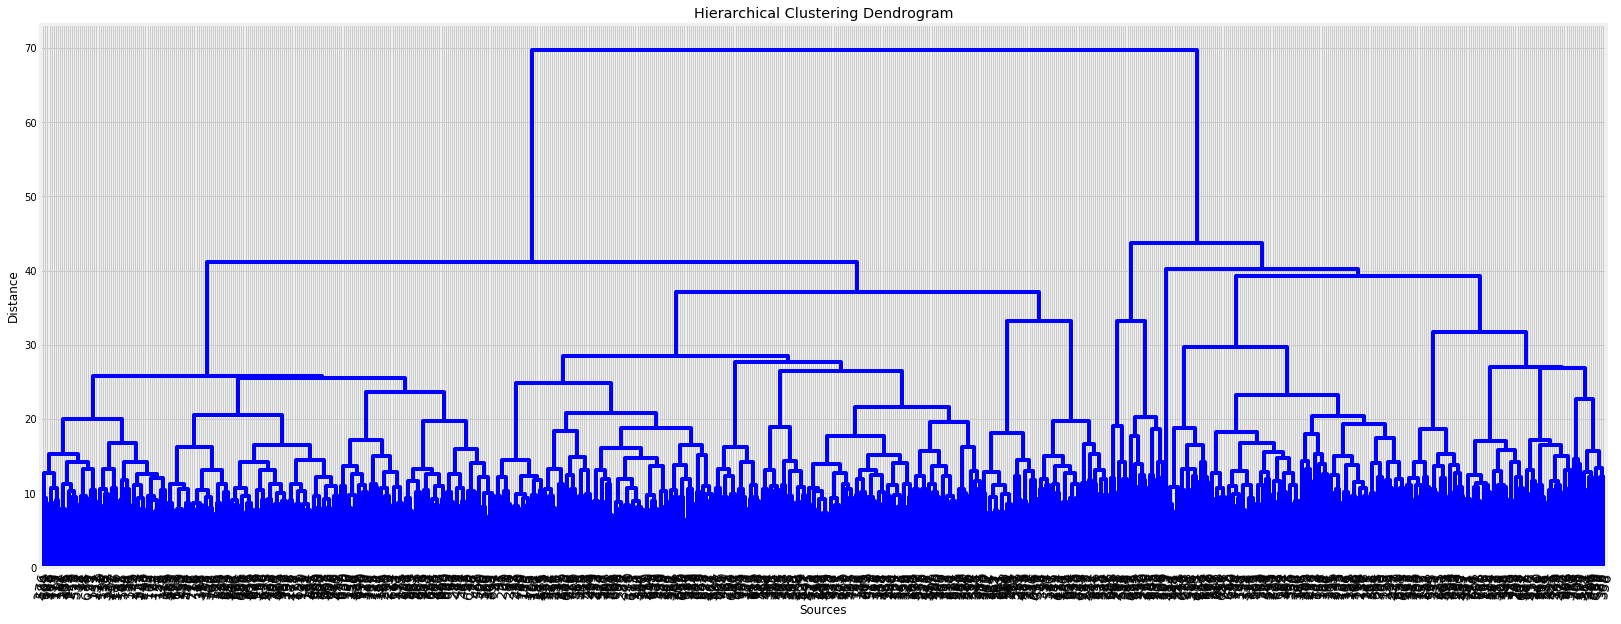

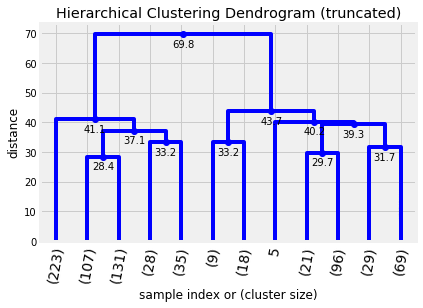

In [8]:
test_find_clusters_en(get_dataframe_analysis_en(True))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  app.launch_new_instance()


,Clasifica tu grado de visión,"Cuando compartes imágenes, ¿habitualmente las envías a otras personas?","Cuando compartes imágenes, ¿habitualmente las produces tú?","Cuando compartes imágenes, ¿habitualmente las recibes de otras personas?","Cuando generas una imagen, ¿qué tipo de dispositivo usas? (Respuesta múltiple) [1. Cámara de fotos]","Cuando generas una imagen, ¿qué tipo de dispositivo usas? (Respuesta múltiple) [2. Teléfono móvil]","Cuando generas una imagen, ¿qué tipo de dispositivo usas? (Respuesta múltiple) [3. Tableta]","Cuando observas estas imágenes, ¿entiendes lo que pasa, aunque los sujetos/objetos no se muestren de forma completa? 1 2 3 4","Cuando observas una imagen, ¿te preguntas cosas acerca de los personajes/objetos que aparecen en la misma?","Cuando produces imágenes, ¿cuánto tiempo dedicas a prepararlas? (minutos)",...,¿Qué imágenes decides compartir en redes sociales u otros medios tecnológicos? (Respuesta múltiple) [4. Imágenes que con las que pretendo causar una reacción (ej. likes)],"¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [1. Apps de contenidos audiovisuales (Netflix, HBO, etc.)]","¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [2. Aplicaciones de mensajería (Whatsapp, Facebook Messenger, etc.)]","¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [3. Bibliotecas de fotos online (Google Photos, iPhoto, etc.)]","¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [4. Redes sociales (Facebook, Instagram, Twitter, etc.).]","¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [5. Aplicaciones de vídeo (Youtube, Vimeo, etc.).]",¿Repites las imágenes hasta conseguir el resultado esperado?,"¿Tienes acceso a dispositivos (ordenador, móvil, tablet, etc.) conectados a Internet habitualmente?","¿Tienes alguna carencia visual que afecte a la recepción de formas, colores, distancias, etc.?",¿Utilizas gafas o lentes de contacto?
0,-1.218193,-0.320940,1.017927,-0.329682,-0.781885,0.3119,-0.288675,-0.180359,0.506719,-0.108243,...,-0.656483,0.892330,0.515438,1.006540,0.484876,0.620062,0.597932,0.542426,-0.430664,0.965396
1,-1.218193,1.810326,1.017927,1.804210,-0.781885,0.3119,-0.288675,-0.180359,0.506719,-0.108243,...,-0.656483,0.892330,0.515438,-0.993502,-2.062383,0.620062,-1.672432,0.542426,-0.430664,0.965396
2,-0.035466,-0.320940,1.017927,0.737264,-0.781885,0.3119,-0.288675,-0.180359,-0.524192,-0.108243,...,-0.656483,0.892330,0.515438,1.006540,0.484876,0.620062,0.597932,0.542426,-0.430664,0.965396
3,-0.035466,0.744693,1.017927,-1.396628,1.278960,0.3119,-0.288675,-0.180359,0.506719,-0.039677,...,1.523268,-1.120662,0.515438,1.006540,0.484876,0.620062,0.597932,0.542426,-0.430664,0.965396
4,-0.035466,0.744693,-0.156133,0.737264,1.278960,0.3119,-0.288675,-0.180359,-0.524192,-0.039677,...,1.523268,-1.120662,0.515438,-0.993502,0.484876,0.620062,0.597932,0.542426,-0.430664,0.965396


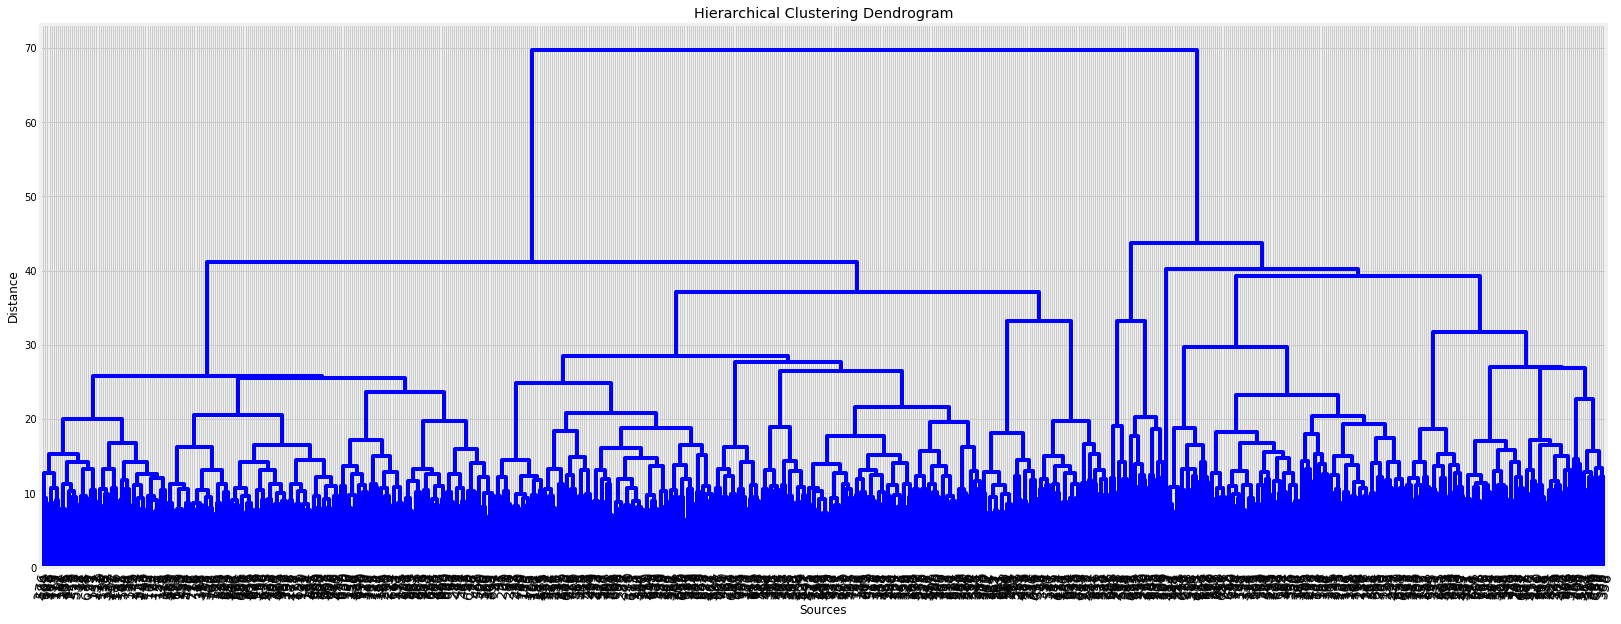

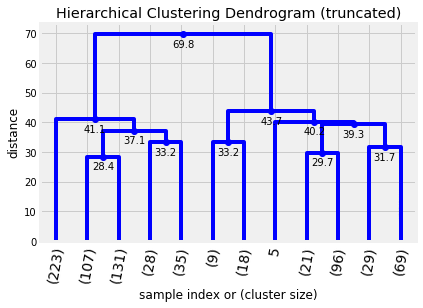

In [9]:
test_find_clusters_esp(get_dataframe_analysis_esp(True))

## Obtaining clusters from data

These functions obtain the clusters from a dataframe and return another dataframe with a new column called `cultural_cluster` which represents the cluster related to cultural aspects assigned to each participant 

Also, we include two examples to show how to use the functions. The Euclidean distance used as a cutoff point to get the clusters in the examples is '28' as shown in the graphs displayed in the test functions `test_find_clusters_en()` and `test_find_clusters_esp()`

In [10]:
def get_dataframe_with_clusters_en(dataframe, max_euc_distance):
    
    clusters = dataframe.copy(True)
    clusters = drop_text_columns_en(clusters)
    clusters = drop_optional_columns_en(clusters)

    all_cultural_items, _, _, _ = get_cultural_items_en()

    my_subset = all_cultural_items
    clusters = clusters[sorted(clusters, key=lambda x: x not in my_subset)]

    columns_vC = clusters.columns.values.tolist()

    for item in all_cultural_items:
        columns_vC.remove(item)

    z_vCluster = scale(clusters.iloc[:, len(my_subset):])
    z_vCluster = pd.DataFrame(z_vCluster, columns=columns_vC)

    # display(z_vCluster.head())

    # Fitting our model.
    cluster_tree = linkage(z_vCluster, 'ward')
    
    dataframe_with_clusters = clusters
    clusters_got = fcluster(cluster_tree, max_euc_distance, criterion='distance')
    dataframe_with_clusters['cultural_cluster'] = clusters_got
    
    return dataframe_with_clusters

In [11]:
def get_dataframe_with_clusters_esp(dataframe, max_euc_distance):
    
    clusters = dataframe.copy(True)
    clusters = drop_text_columns_esp(clusters)
    clusters = drop_optional_columns_esp(clusters)

    all_cultural_items, _, _, _ = get_cultural_items_esp()

    my_subset = all_cultural_items
    clusters = clusters[sorted(clusters, key=lambda x: x not in my_subset)]

    columns_vC = clusters.columns.values.tolist()

    for item in all_cultural_items:
        columns_vC.remove(item)

    z_vCluster = scale(clusters.iloc[:, len(my_subset):])
    z_vCluster = pd.DataFrame(z_vCluster, columns=columns_vC)

    # display(z_vCluster.head())

    # Fitting our model.
    cluster_tree = linkage(z_vCluster, 'ward')
    
    dataframe_with_clusters = clusters
    clusters_got = fcluster(cluster_tree, max_euc_distance, criterion='distance')
    dataframe_with_clusters['cultural_cluster'] = clusters_got
    
    return dataframe_with_clusters

In [12]:
dataframe_with_clusters_en = get_dataframe_with_clusters_en(get_dataframe_analysis_en(True), 28)

print("Number of clusters: "+ str(len(dataframe_with_clusters_en['cultural_cluster'].unique())))
dataframe_with_clusters_en['cultural_cluster'].value_counts()

Number of clusters: 12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.


1     223
3     131
2     107
9      96
11     69
5      35
10     29
4      28
8      21
7      18
6       9
12      1
Name: cultural_cluster, dtype: int64

In [13]:
dataframe_with_clusters_esp = get_dataframe_with_clusters_esp(get_dataframe_analysis_esp(True), 28)

print("Número de clusters: "+ str(len(dataframe_with_clusters_esp['cultural_cluster'].unique())))
dataframe_with_clusters_esp['cultural_cluster'].value_counts()

Número de clusters: 12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.


1     223
3     131
2     107
9      96
11     69
5      35
10     29
4      28
8      21
7      18
6       9
12      1
Name: cultural_cluster, dtype: int64